In [1]:
# ## Cell 1: 모듈 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# src 폴더를 경로에 추가하여 analysis 모듈을 임포트
sys.path.append('../src')
import analysis

# 그래프 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'AppleGothic' # macOS
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [2]:
# ## Cell 2: 데이터 로드 및 전처리
# main.py 실행 후 생성된 결과 파일 경로를 지정
results_file = Path("../results/page_10/evaluation_results/eval_results.jsonl")

# analysis.py의 함수들을 사용하여 데이터프레임 생성
base_df = analysis.load_and_flatten_results(results_file)
processed_df = analysis.calculate_ensemble_scores(base_df)

print("데이터프레임 정보:")
processed_df.info()
print("\n처리된 데이터프레임 샘플:")
processed_df.head()

2025-09-22 21:54:57 - INFO - 앙상블 점수 계산이 완료되었습니다.


데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doc_id               105 non-null    object 
 1   page_id              105 non-null    object 
 2   model                105 non-null    object 
 3   combo                105 non-null    object 
 4   question_text        105 non-null    object 
 5   question_type        105 non-null    object 
 6   question_difficulty  105 non-null    object 
 7   answer               105 non-null    object 
 8   prompt_tokens        105 non-null    int64  
 9   completion_tokens    105 non-null    int64  
 10  judge                105 non-null    object 
 11  accuracy             105 non-null    float64
 12  groundedness         105 non-null    float64
 13  completeness         105 non-null    float64
 14  clarity              105 non-null    float64
 15  final_score          105 non-

,doc_id,page_id,model,combo,question_text,question_type,question_difficulty,answer,prompt_tokens,completion_tokens,judge,accuracy,groundedness,completeness,clarity,final_score,answer_id,normalized_score,ensemble_score
0,page_10,page_10,gpt-4o,M1,필터의 조합형은 무엇인가요?,fact_extraction,Easy,"필터의 조합형은 ""Season""입니다. (이미지의 ""Season 조합형"" 설명 참고)",1202,25,gpt-4o,0.0,0.0,0.0,5.0,0.50,3,-0.688889,0.207407
1,page_10,page_10,gpt-4o,M1,필터의 조합형은 무엇인가요?,fact_extraction,Easy,"필터의 조합형은 ""Season""입니다. (이미지의 ""Season 조합형"" 설명 참고)",1202,25,gemini-1.5-pro,5.0,5.0,5.0,5.0,5.00,3,1.311111,0.207407
2,page_10,page_10,gpt-4o,M1,필터의 조합형은 무엇인가요?,fact_extraction,Easy,"필터의 조합형은 ""Season""입니다. (이미지의 ""Season 조합형"" 설명 참고)",1202,25,claude-sonnet-4,2.0,2.0,1.0,4.0,2.05,3,0.000000,0.207407
3,page_10,page_10,gpt-4o,M2,필터의 조합형은 무엇인가요?,fact_extraction,Easy,"필터의 조합형은 ""Season""입니다. (이미지의 ""Season 조합형"" 설명 참고)",1202,25,gpt-4o,0.0,0.0,0.0,5.0,0.50,8,-0.688889,0.207407
4,page_10,page_10,gpt-4o,M2,필터의 조합형은 무엇인가요?,fact_extraction,Easy,"필터의 조합형은 ""Season""입니다. (이미지의 ""Season 조합형"" 설명 참고)",1202,25,gemini-1.5-pro,5.0,5.0,5.0,5.0,5.00,8,1.311111,0.207407


In [3]:
# ## Cell 3: 전체 성능 요약
print("\n입력 조합(combo)별 앙상블 점수 요약:")
summary = processed_df.groupby('combo')['ensemble_score'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
print(summary)


입력 조합(combo)별 앙상블 점수 요약:
           mean       std  count
combo                           
M2    -0.107503  0.304517     15
M3    -0.163934  0.359629     15
M1    -0.225185  0.381266     15
M4    -0.384106  0.326015     15
M5    -0.389855  0.364149     15
M6    -0.400000  0.338062     15
M7    -0.400000  0.338062     15


In [4]:
# ## Cell 4: 심사관 간 일치도(IAA) 계산
alpha = analysis.calculate_krippendorff_alpha(processed_df)
print(f"\n전체 심사관 간 일치도 (Krippendorff's Alpha): {alpha:.4f}")

2025-09-22 21:55:03 - INFO - Krippendorff's Alpha: 0.3462



전체 심사관 간 일치도 (Krippendorff's Alpha): 0.3462


2025-09-22 21:55:06 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-22 21:55:06 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


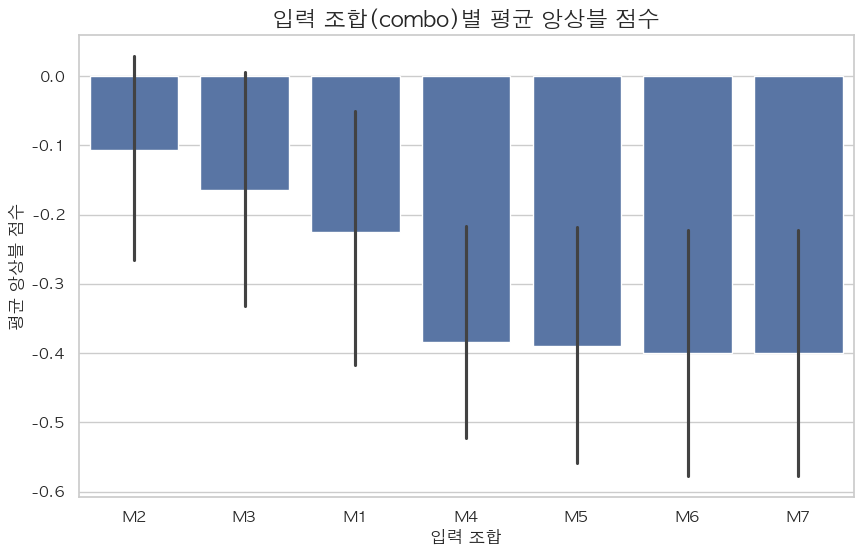

In [5]:
# ## Cell 5: 성능 시각화 (막대그래프)
plt.figure(figsize=(10, 6))
sns.barplot(data=processed_df, x='combo', y='ensemble_score', order=summary.index)
plt.title('입력 조합(combo)별 평균 앙상블 점수', fontsize=16)
plt.xlabel('입력 조합', fontsize=12)
plt.ylabel('평균 앙상블 점수', fontsize=12)
plt.show()

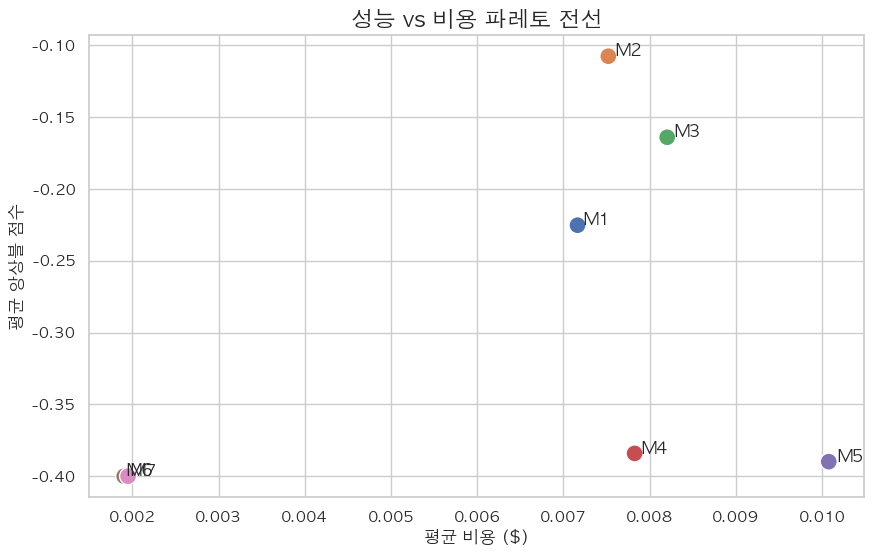

In [6]:
# ## Cell 6: 파레토 최적 전선(Pareto Frontier) 시각화
# 비용 계산 (예시: 토큰당 가격)
# 실제 가격은 모델별로 다르므로, 여기서는 단순화된 예시를 사용합니다.
PRICING = {
    "prompt_tokens": 0.005 / 1000, # $0.005 per 1k tokens
    "completion_tokens": 0.015 / 1000 # $0.015 per 1k tokens
}
processed_df['cost'] = (processed_df['prompt_tokens'] * PRICING['prompt_tokens'] + 
                        processed_df['completion_tokens'] * PRICING['completion_tokens'])

# 콤보별 평균 점수 및 비용 계산
pareto_data = processed_df.groupby('combo').agg(
    avg_score=('ensemble_score', 'mean'),
    avg_cost=('cost', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pareto_data, x='avg_cost', y='avg_score', s=150, hue='combo', legend=False)
plt.title('성능 vs 비용 파레토 전선', fontsize=16)
plt.xlabel('평균 비용 ($)', fontsize=12)
plt.ylabel('평균 앙상블 점수', fontsize=12)

# 각 점에 라벨 추가
for i, point in pareto_data.iterrows():
    plt.text(point['avg_cost'] * 1.01, point['avg_score'], point['combo'], fontsize=12)

plt.show()

In [7]:
import itertools
from scipy import stats

# `processed_df`에서 각 M 조합에 해당하는 점수 데이터(예: final_score)를 추출합니다.
# `combo` 컬럼의 고유한 값들을 사용하여 그룹화합니다.
# 각 그룹의 'final_score' 값을 리스트로 저장합니다.
combo_scores = {
    combo: group['final_score'].tolist()
    for combo, group in processed_df.groupby('combo')
}

# 'M'으로 시작하는 메트릭 이름만 필터링합니다.
metrics = [combo for combo in combo_scores if combo.startswith('M')]
# `summary` 인덱스를 사용하고 싶다면, `metrics` 리스트를 다음과 같이 변경할 수도 있습니다.
# metrics = [f'M{i}' for i in range(1, 8) if f'M{i}' in summary.index]

# 위에서 찾은 메트릭들의 모든 두 개 조합을 생성합니다.
metric_pairs = list(itertools.combinations(metrics, 2))

# 각 조합에 대해 통계 검정을 수행하고 결과를 저장합니다.
test_results = []
for m1, m2 in metric_pairs:
    # 두 조합에 해당하는 데이터가 모두 존재하는지 확인
    if m1 in combo_scores and m2 in combo_scores:
        # `analysis.run_statistical_test` 함수가 두 개의 리스트를 인자로 받는다고 가정
        # 실제 함수에 맞게 인자를 조정해야 할 수 있습니다. (e.g., stats.wilcoxon(x, y))
        # stat, p_value = analysis.run_statistical_test(combo_scores[m1], combo_scores[m2])
        
        # 예시로 Wilcoxon 검정 함수를 직접 사용합니다.
        # 동일한 질문에 대한 쌍을 비교하므로 paired test를 수행합니다.
        stat, p_value = stats.wilcoxon(combo_scores[m1], combo_scores[m2])

        test_results.append({
            'pair': (m1, m2),
            'p_value': p_value
        })

# p-value를 기준으로 오름차순으로 정렬합니다.
sorted_results = sorted(test_results, key=lambda x: x['p_value'])

print("--- M1부터 M7까지 모든 조합의 통계 검정 결과 (p-value 기준 오름차순) ---")

# 정렬된 결과를 보기 좋게 출력합니다.
for result in sorted_results:
    m1, m2 = result['pair']
    p_value = result['p_value']
    
    print(f"\n--- {m1} vs {m2} 통계 검정 결과 ---")
    print(f"Wilcoxon signed-rank test p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).")
    else:
        print(f"결론: 두 조합 간의 성능 차이는 통계적으로 유의미하지 않습니다 (p >= 0.05).")

--- M1부터 M7까지 모든 조합의 통계 검정 결과 (p-value 기준 오름차순) ---

--- M2 vs M6 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0076
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M2 vs M7 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0116
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M1 vs M2 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0180
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M2 vs M3 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0208
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M2 vs M4 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0208
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M5 vs M6 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0340
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M5 vs M7 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0340
결론: 두 조합 간의 성능 차이는 통계적으로 **유의미합니다** (p < 0.05).

--- M3 vs M5 통계 검정 결과 ---
Wilcoxon signed-rank test p-value: 0.0630
결론: 두 조합 간의 성능 차이는 통계적으로 유의미하지 않습니다 (p >= 0.05).

--- M4 vs 